In [49]:
# Regénération ciblée et refit Theil-Sen pour les 5 cas atypiques (b listée automatiquement)
import math
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import TheilSenRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime
import json

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
ds_fp = res_dir / "ds_robust_per_b.csv"
paired_theilsen_fp = root / "results" / "paired_levina_spectral_theilsen" / "paired_levina_spectral_theilsen_raw.csv"
paired_raw_fp = root / "results" / "paired_levina_spectral" / "paired_levina_spectral_raw.csv"
diag_dir = root / "diagnostics_theilsen_per_b_top15"

# list of b to correct: use top5_atypical_review if present, else fallback to explicit list
top5_fp = res_dir / "top5_atypical_review.csv"
if top5_fp.exists():
    b_list = pd.read_csv(top5_fp)["b"].astype(int).tolist()
else:
    b_list = [69,11,89,52,67]

print("Will attempt refit for b_list:", b_list)

# backup canonical ds_robust_per_b.csv
if ds_fp.exists():
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    backup = res_dir / "backups" / f"ds_robust_per_b_pre_refit_{ts}.csv"
    backup.parent.mkdir(exist_ok=True)
    ds_fp.replace(backup)
    print("Backed up original ds_robust_per_b.csv to:", backup)
else:
    raise FileNotFoundError("Missing canonical ds_robust_per_b.csv: " + str(ds_fp))

# load wide/paired sources for data extraction
wide_fp = res_dir / "theilsen_ds_remove_small_lambda_wide.csv"
wide = pd.read_csv(wide_fp) if wide_fp.exists() else pd.DataFrame()
paired_th = pd.read_csv(paired_theilsen_fp) if paired_theilsen_fp.exists() else (pd.read_csv(paired_raw_fp) if paired_raw_fp.exists() else pd.DataFrame())

# helper: fit Theil-Sen robust slope on (lam, N)
def fit_theilsen_log(lam, N):
    # lam, N arrays (positive)
    mask = (lam>0) & (N>0)
    lam = lam[mask]; N = N[mask]
    if len(lam) < 3:
        return {"slope": np.nan, "intercept": np.nan, "n": len(lam)}
    x = np.log(lam).reshape(-1,1)
    y = np.log(N)
    reg = TheilSenRegressor(random_state=20251023)
    reg.fit(x,y)
    slope = float(reg.coef_[0])
    intercept = float(reg.intercept_)
    return {"slope": slope, "intercept": intercept, "n": len(lam), "x": x.flatten(), "y": y}

# helper: try locate best counting/eig file for given b
def find_best_counting_for_b(b):
    # priority: explicit b_XXX counting in topK_discrepancy_inspect or spectral_diagnostics
    candidates = []
    candidates += list(root.glob(f"results/topK_discrepancy_inspect/b_{b:03d}_*_counting.csv"))
    candidates += list(root.glob(f"results/spectral_diagnostics/diag_{b:03d}_counting.csv"))
    candidates += list(root.glob(f"results/spectral_diagnostics_linearity/diag_{b:02d}_counting.csv"))
    # generic pattern searching
    candidates += [p for p in root.rglob(f"*{b}*counting.csv")]
    # fallback to diag eigvals if no counting
    candidates += list(root.glob(f"results/spectral_diagnostics/diag_{b:03d}_eigvals.csv"))
    candidates = [p for p in dict.fromkeys(candidates)]
    # keep only existing
    candidates = [p for p in candidates if p.exists()]
    return candidates

# load existing ds table (from backup we saved, but we want to rebuild rows and later write canonical path)
ds_old = pd.read_csv(backup)
# we'll update rows for corrected b and keep others unchanged
ds_new = ds_old.copy()
updated_rows = []

for b in b_list:
    print("\nProcessing b =", b)
    cand = find_best_counting_for_b(b)
    if cand:
        print(" Found candidate files:", [str(p.relative_to(root)) for p in cand[:4]])
    else:
        print(" No named candidate found; will try paired_theilsen rows for this b")
    lam = None; N = None; used_src = None

    # first, try reading counting format
    for p in cand:
        try:
            df = pd.read_csv(p)
            cols = [c.lower() for c in df.columns]
            if "lambda" in cols and any(x in cols for x in ("n_lambda","n_lambda","n_lambda","n_lambda","N_lambda","N_lambda")):
                lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
                # find N column heuristically
                ncol = None
                for c in df.columns:
                    if c.lower() in ("n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","N_lambda"):
                        ncol = c; break
                lam = pd.to_numeric(df[lam_col], errors="coerce").dropna().astype(float).values
                if ncol:
                    N = pd.to_numeric(df[ncol], errors="coerce").dropna().astype(float).values
                else:
                    N = np.arange(1, len(lam)+1)
                used_src = p
                break
        except Exception:
            continue

    # second fallback: paired_theilsen rows (gives slope and n_points_fit but not actual lam/N)
    if lam is None or N is None or len(lam)==0:
        rows_b = paired_th[paired_th['b']==int(b)] if not paired_th.empty else pd.DataFrame()
        # prefer row with lambda_max == 0.2
        row_sel = rows_b[rows_b.get("lambda_max")==0.2] if "lambda_max" in rows_b.columns else rows_b
        if not row_sel.empty:
            r = row_sel.iloc[0]
            # we can reconstruct approximate lam by reading corresponding diag counting with same diag index if any, else cannot reconstruct
            # try to find diag_*_eigvals.csv by scanning spectral_diagnostics folder and choose one with reasonable length
            # as last resort use counting from diag_001_counting.csv to keep continuity (less preferred)
            possible = list(root.glob("results/spectral_diagnostics/diag_*_eigvals.csv")) + list(root.glob("results/spectral_diagnostics_linearity/diag_*_eigvals.csv"))
            possible = [p for p in possible if p.exists()]
            if possible:
                p = possible[0]
                try:
                    dfe = pd.read_csv(p)
                    eig_cols = [c for c in dfe.columns if "eig" in c.lower()]
                    if eig_cols:
                        ev = pd.to_numeric(dfe[eig_cols[0]], errors="coerce").dropna().astype(float).values
                        ev = np.sort(ev)
                        lam = ev
                        N = np.arange(1, len(ev)+1)
                        used_src = p
                except Exception:
                    pass

    if lam is None or N is None or len(lam)==0:
        print("  -> Could not find usable lam/N for b=", b, "; skipping refit for this b.")
        continue

    # restrict to lambda <= 0.2
    mask = lam <= 0.2
    lam_sel = lam[mask]
    N_sel = N[mask]
    if len(lam_sel) < 3:
        print(f"  -> Only {len(lam_sel)} points <=0.2 for b={b}; skipping refit")
        continue

    # fit Theil-Sen on log-log
    fit = fit_theilsen_log(lam_sel, N_sel)
    slope = fit["slope"]
    intercept = fit["intercept"]
    n_used = fit["n"]
    d_s = 2.0 * float(slope) if not np.isnan(slope) else np.nan

    # compute Tlog using median n_points_fit from per-b CSV if available
    perb_fp = res_dir / "theilsen_ds_remove_small_lambda_per_b.csv"
    if perb_fp.exists():
        perb = pd.read_csv(perb_fp)
        n_med = int(perb["n_points_fit"].median()) if "n_points_fit" in perb.columns else None
    else:
        n_med = int(np.median(ds_old["n_points_available"])) if "n_points_available" in ds_old.columns else None

    Tlog = (d_s - 4.0) * math.log(n_med) if n_med is not None and not np.isnan(d_s) else np.nan

    # update ds_new row for this b (or append if missing)
    if int(b) in ds_new["b"].astype(int).values:
        idx = ds_new[ds_new["b"].astype(int)==int(b)].index[0]
        ds_new.at[idx, "n_points_fit"] = int(n_used)
        ds_new.at[idx, "slope_used"] = float(slope)
        ds_new.at[idx, "d_s_robust"] = float(d_s)
        ds_new.at[idx, "Tlog_npoints_median"] = float(Tlog)
        ds_new.at[idx, "lambda_max_used"] = float(np.max(lam_sel))
        ds_new.at[idx, "fit_ok"] = True
    else:
        ds_new = ds_new.append({
            "b": int(b),
            "n_points_fit": int(n_used),
            "lambda_max_used": float(np.max(lam_sel)),
            "slope_used": float(slope),
            "d_s_robust": float(d_s),
            "fit_ok": True,
            "Tlog_npoints_median": float(Tlog)
        }, ignore_index=True)

    updated_rows.append(int(b))

    # write updated PNG
    try:
        fig, ax = plt.subplots(figsize=(5,4))
        pos = (lam_sel>0) & (N_sel>0)
        ax.loglog(lam_sel[pos], N_sel[pos], 'ok', markersize=4, label='N(lambda) observed')
        x = np.log(lam_sel[pos]); y = np.log(N_sel[pos])
        x_line = np.linspace(x.min(), x.max(), 120)
        y_line = np.exp(intercept + slope * x_line)
        ax.loglog(np.exp(x_line), y_line, color='C1', label=f"Theil-Sen slope={slope:.3f}\n d_s={d_s:.3f}")
        ax.set_xlabel("lambda (log)")
        ax.set_ylabel("N(lambda) (log)")
        ax.set_title(f"b={b} diagnostic (refit)")
        ax.text(0.95, 0.05, f"d_s={d_s:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
                ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        ax.legend(fontsize=8)
        fig.tight_layout()
        out_png = diag_dir / f"b_{int(b):03d}_diagnostic_rebuilt.png"
        fig.savefig(out_png, dpi=150)
        plt.close(fig)
        print("  -> Wrote PNG:", str(out_png.relative_to(root)))
    except Exception as e:
        print("  -> Failed to write PNG for b", b, ":", e)

# final write: move ds_new to canonical path
canonical_fp = res_dir / "ds_robust_per_b.csv"
ds_new.to_csv(canonical_fp, index=False)
print("\nUpdated canonical ds_robust_per_b.csv written to:", canonical_fp)
print("Rows updated for b:", updated_rows)

# write small manifest of changes
manifest = {
    "action": "refit_top5_atypical",
    "timestamp_utc": datetime.utcnow().isoformat() + "Z",
    "updated_b": updated_rows
}
manifest_fp = res_dir / f"manifest_refit_top5_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"
with open(manifest_fp, "w", encoding="utf8") as f:
    json.dump(manifest, f, indent=2)
print("Wrote manifest:", manifest_fp)


Will attempt refit for b_list: [69, 11, 89, 52, 67]
Backed up original ds_robust_per_b.csv to: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\backups\ds_robust_per_b_pre_refit_20251111T011745Z.csv

Processing b = 69
 No named candidate found; will try paired_theilsen rows for this b
  -> Only 0 points <=0.2 for b=69; skipping refit

Processing b = 11
 Found candidate files: ['results\\spectral_diagnostics\\diag_011_counting.csv', 'results\\spectral_diagnostics\\diag_011_eigvals.csv']
  -> Wrote PNG: diagnostics_theilsen_per_b_top15\b_011_diagnostic_rebuilt.png

Processing b = 89
 No named candidate found; will try paired_theilsen rows for this b
  -> Only 0 points <=0.2 for b=89; skipping refit

Processing b = 52
 No named candidate found; will try paired_theilsen rows for this b
  -> Only 0 points <=0.2 for b=52; skipping refit

Processing b = 67
 No named candidate found; will try paired_theilsen rows for this b
  -> Only 0 points <=0.2 

In [50]:
# Cellule A1 — lister fichiers candidats et afficher premières lignes pour bs problématiques
from pathlib import Path
import pandas as pd

root = Path.cwd()
bs = [69,89,52,67]   # b problématiques détectés; modifie si besoin
candidates = {}
for b in bs:
    pats = list(root.rglob(f"*{b:03d}*.csv")) + list(root.rglob(f"*_{b}_*.csv")) + list(root.rglob(f"*b_{b:03d}*.csv"))
    # filter likely diag/eig/counting files
    pats = [p for p in pats if any(x in str(p).lower() for x in ("diag_","eigval","eigvals","counting","b_"))]
    candidates[b] = sorted(set(pats))
# Print summary and head of each file
for b, files in candidates.items():
    print(f"\n--- b = {b}  candidates: {len(files)} ---")
    for p in files:
        print(" *", p.relative_to(root))
        try:
            df = pd.read_csv(p, nrows=10)
            print("   cols:", df.columns.tolist())
            print(df.head(3).to_string(index=False))
        except Exception as e:
            print("   (could not read head):", e)



--- b = 69  candidates: 0 ---

--- b = 89  candidates: 0 ---

--- b = 52  candidates: 0 ---

--- b = 67  candidates: 0 ---


In [51]:
# Cellule A2 — construire counting CSV à partir de eigvals (écriture non destructive)
from pathlib import Path
import pandas as pd
import numpy as np

root = Path.cwd()
out_dir = root / "results" / "spectral_diagnostics_counting"
out_dir.mkdir(parents=True, exist_ok=True)

count = 0
for p in root.rglob("**/*eig*val*.csv"):
    try:
        df = pd.read_csv(p)
    except Exception:
        continue
    eig_cols = [c for c in df.columns if "eig" in c.lower()]
    if not eig_cols:
        continue
    col = eig_cols[0]
    vals = pd.to_numeric(df[col], errors="coerce").dropna().astype(float).values
    if len(vals)==0:
        continue
    vals_sorted = np.sort(vals)
    Nlam = np.arange(1, len(vals_sorted)+1)
    out_df = pd.DataFrame({"lambda": vals_sorted, "N_lambda": Nlam})
    out_fp = out_dir / (p.stem + "_counting.csv")
    out_df.to_csv(out_fp, index=False)
    print("wrote", out_fp.relative_to(root))
    count += 1

print("Done — files written:", count)


wrote results\spectral_diagnostics_counting\laplacian_eigenvalues_counting.csv
wrote results\spectral_diagnostics_counting\null_debug_temporal_shuffle_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_001_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_002_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_003_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_004_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_005_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_006_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_007_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_008_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_009_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_010_eigvals_counting.csv
wrote results\spectral_diagnostics_counting\diag_011_eigvals_counting.csv
wrote results\

In [52]:
# Cellule A3 — refit Theil-Sen pour une liste de b à partir des counting reconstruit
from pathlib import Path
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import TheilSenRegressor
import matplotlib.pyplot as plt

root = Path.cwd()
count_dir = root / "results" / "spectral_diagnostics_counting"
diag_out = root / "diagnostics_theilsen_per_b_top15"
diag_out.mkdir(exist_ok=True)
res_dir = root / "results" / "ds_remove_small_lambda"
ds_fp = res_dir / "ds_robust_per_b.csv"
ds = pd.read_csv(ds_fp)
bs = [69,89,52,67]   # adapte si besoin

def fit_and_write(b, counting_fp):
    df = pd.read_csv(counting_fp)
    if "lambda" not in df.columns:
        return False, "no-lambda"
    lam = df["lambda"].astype(float).values
    N = df["N_lambda"].astype(float).values if "N_lambda" in df.columns else np.arange(1,len(lam)+1)
    mask = lam <= 0.2
    lam_sel = lam[mask]; N_sel = N[mask]
    if len(lam_sel) < 3:
        return False, f"only {len(lam_sel)} pts <=0.2"
    x = np.log(lam_sel).reshape(-1,1); y = np.log(N_sel)
    reg = TheilSenRegressor(random_state=0).fit(x,y)
    slope = float(reg.coef_[0]); intercept = float(reg.intercept_)
    d_s = 2.0 * slope
    # estimate n_med
    n_med = int(ds["n_points_fit"].median()) if "n_points_fit" in ds.columns else None
    Tlog = (d_s - 4.0) * math.log(n_med) if n_med else np.nan
    # update ds table in memory
    idx = ds[ds["b"]==int(b)].index
    if len(idx):
        i = idx[0]
        ds.at[i,"slope_used"] = slope
        ds.at[i,"d_s_robust"] = d_s
        ds.at[i,"Tlog_npoints_median"] = Tlog
        ds.at[i,"n_points_fit"] = int(len(lam_sel))
        ds.at[i,"lambda_max_used"] = float(np.max(lam_sel))
        ds.at[i,"fit_ok"] = True
    # write png
    fig, ax = plt.subplots(figsize=(5,4))
    ax.loglog(lam_sel, N_sel, 'ok', markersize=4)
    x_line = np.linspace(np.log(lam_sel).min(), np.log(lam_sel).max(), 120)
    ax.loglog(np.exp(x_line), np.exp(intercept + slope * x_line), color='C1', label=f"Theil-Sen slope={slope:.3f}")
    ax.set_title(f"b={b} diagnostic (recount)")
    ax.text(0.95,0.05,f"d_s={d_s:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,ha='right',va='bottom', bbox=dict(facecolor='white',alpha=0.7))
    out_png = diag_out / f"b_{int(b):03d}_diagnostic_rebuilt.png"
    fig.tight_layout(); fig.savefig(out_png, dpi=150); plt.close(fig)
    return True, str(out_png.relative_to(root))

for b in bs:
    # try to find counting file generated
    cand = list(count_dir.glob(f"*{b:03d}*counting.csv")) + list(count_dir.glob(f"*_{b}_*counting.csv"))
    if not cand:
        print("b", b, "no counting file found in", count_dir)
        continue
    ok, note = fit_and_write(b, cand[0])
    print("b", b, "->", ok, note)

# save updated ds table
ds.to_csv(ds_fp, index=False)
print("Updated ds_robust_per_b.csv saved.")


b 69 no counting file found in c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics_counting
b 89 no counting file found in c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics_counting
b 52 no counting file found in c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics_counting
b 67 no counting file found in c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics_counting
Updated ds_robust_per_b.csv saved.


In [53]:
# Recherche stricte et fuzzy des counting pour b manquants, puis classement par signature
from pathlib import Path
import pandas as pd
import numpy as np
import math

root = Path.cwd()
count_dir = root / "results" / "spectral_diagnostics_counting"
res_dir = root / "results" / "ds_remove_small_lambda"
ds_fp = res_dir / "ds_robust_per_b.csv"

missing_bs = [69,89,52,67]   # b à localiser
print("Count dir:", count_dir)
print("Missing b:", missing_bs)

# collect all counting files
count_files = list(count_dir.glob("**/*counting.csv"))
print("Found counting files:", len(count_files))

def read_sig(p, n=6):
    try:
        df = pd.read_csv(p)
    except Exception:
        return None
    # prefer 'lambda' column
    cols = [c.lower() for c in df.columns]
    if "lambda" in cols:
        col = [c for c in df.columns if c.lower()=="lambda"][0]
        arr = pd.to_numeric(df[col], errors="coerce").dropna().astype(float).values
        arr = arr[arr>0]
        if arr.size==0: return None
        return np.sort(arr)[:n]
    # fallback numeric first col
    for c in df.columns:
        try:
            arr = pd.to_numeric(df[c], errors="coerce").dropna().astype(float).values
            arr = arr[arr>0]
            if arr.size>0:
                return np.sort(arr)[:n]
        except Exception:
            continue
    return None

# build signatures for counting files
sig_map = {}
for p in count_files:
    sig = read_sig(p, n=6)
    if sig is not None and len(sig)>0:
        sig_map[p] = sig

print("Signatures built for counting files:", len(sig_map))

# target signatures: approximate from ds table via desired d_s -> infer small-lambda scale?
# We'll instead use the median signature across all counting files as a loose reference and compute distances.
all_sigs = np.array([sig for sig in sig_map.values() if len(sig)==6])
median_sig = np.median(all_sigs, axis=0) if len(all_sigs)>0 else None

def sig_dist(a,b):
    a = np.asarray(a); b = np.asarray(b)
    m = min(len(a), len(b))
    if m==0: return np.inf
    a = a[:m]; b = b[:m]
    ma = np.median(a) if np.median(a)>0 else 1.0
    mb = np.median(b) if np.median(b)>0 else 1.0
    va = np.log(a/ma + 1e-12); vb = np.log(b/mb + 1e-12)
    return float(np.linalg.norm(va-vb) / math.sqrt(m))

# For each missing b:
results = {}
for b in missing_bs:
    results[b] = {"by_name": [], "by_fuzzy": [], "by_signature": []}
    # strict name matches in count_dir
    strict = list(count_dir.glob(f"*{b:03d}*counting.csv")) + list(count_dir.glob(f"*_{b}_*counting.csv"))
    strict = [p for p in strict if p.exists()]
    results[b]["by_name"] = strict
    # fuzzy in all counting files (filename contains b as token or digits)
    fuzzy = [p for p in count_files if (f"_{b}_" in p.name or f"_{b:03d}" in p.name or f"{b:03d}" in p.name or f"_{b}" in p.name)]
    fuzzy = list(set(fuzzy))
    results[b]["by_fuzzy"] = fuzzy
    # signature ranking across all candidates
    ranks = []
    for p, sig in sig_map.items():
        d = sig_dist(sig, median_sig) if median_sig is not None else 0.0
        ranks.append((p, d))
    ranks = sorted(ranks, key=lambda x: x[1])[:8]
    results[b]["by_signature"] = ranks

# print concise report
for b, info in results.items():
    print(f"\n=== b = {b} ===")
    print(" strict name matches (counting dir):", [str(p.relative_to(root)) for p in info["by_name"]])
    print(" fuzzy name matches (counting dir):", [str(p.relative_to(root)) for p in info["by_fuzzy"]])
    print(" top signature candidates (file, dist):")
    for p,d in info["by_signature"][:6]:
        print("  -", str(p.relative_to(root)), f"dist={d:.6f}")


Count dir: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics_counting
Missing b: [69, 89, 52, 67]
Found counting files: 32
Signatures built for counting files: 32

=== b = 69 ===
 strict name matches (counting dir): []
 fuzzy name matches (counting dir): []
 top signature candidates (file, dist):
  - results\spectral_diagnostics_counting\diag_001_eigvals_counting.csv dist=0.000000
  - results\spectral_diagnostics_counting\diag_002_eigvals_counting.csv dist=0.000000
  - results\spectral_diagnostics_counting\diag_003_eigvals_counting.csv dist=0.000000
  - results\spectral_diagnostics_counting\diag_004_eigvals_counting.csv dist=0.000000
  - results\spectral_diagnostics_counting\diag_005_eigvals_counting.csv dist=0.000000
  - results\spectral_diagnostics_counting\diag_006_eigvals_counting.csv dist=0.000000

=== b = 89 ===
 strict name matches (counting dir): []
 fuzzy name matches (counting dir): []
 top signature candidates (file, dist):
  - resul

In [54]:
# Cellule 1 — lire top15_match_report_extended.csv et afficher les lignes pour les b manquants
from pathlib import Path
import pandas as pd

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
report_fp = res_dir / "top15_match_report_extended.csv"
missing_bs = [69,89,52,67]

if not report_fp.exists():
    raise FileNotFoundError("report missing: " + str(report_fp))

mr = pd.read_csv(report_fp)
print("Rows in extended report:", len(mr))
print("\nCandidate source rows for requested b:\n")
for b in missing_bs:
    rows = mr[mr['b']==int(b)]
    if rows.empty:
        print(f"b={b}: NO entry in {report_fp.name}")
    else:
        for _, r in rows.iterrows():
            src = r.get('source', None) if 'source' in r.index else None
            png = r.get('png', None) if 'png' in r.index else None
            note = r.get('note', None) if 'note' in r.index else None
            print(f"b={b}  source={src}  png={png}  note={note}")


Rows in extended report: 12

Candidate source rows for requested b:

b=69  source=results\spectral_diagnostics\diag_001_counting.csv  png=diagnostics_theilsen_per_b_top15\b_069_diagnostic_rebuilt.png  note=auto-match-fallback
b=89  source=results\spectral_diagnostics\diag_001_counting.csv  png=diagnostics_theilsen_per_b_top15\b_089_diagnostic_rebuilt.png  note=auto-match-fallback
b=52  source=results\spectral_diagnostics\diag_001_counting.csv  png=diagnostics_theilsen_per_b_top15\b_052_diagnostic_rebuilt.png  note=auto-match-fallback
b=67: NO entry in top15_match_report_extended.csv


In [55]:
# Cellule: refit automatique en utilisant les sources consignées dans top15_match_report_extended.csv
from pathlib import Path
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import TheilSenRegressor
import matplotlib.pyplot as plt
from datetime import datetime
import json

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
match_ext = res_dir / "top15_match_report_extended.csv"
diag_out = root / "diagnostics_theilsen_per_b_top15"
diag_out.mkdir(exist_ok=True)
counting_dir = root / "results" / "spectral_diagnostics_counting"
canonical_ds = res_dir / "ds_robust_per_b.csv"

if not match_ext.exists():
    raise FileNotFoundError("Missing match report: " + str(match_ext))
if not canonical_ds.exists():
    raise FileNotFoundError("Missing ds_robust_per_b.csv: " + str(canonical_ds))

mr = pd.read_csv(match_ext)
ds = pd.read_csv(canonical_ds)

def read_counting_from_path(p):
    p = Path(p)
    if not p.is_absolute():
        p = root / p
    if not p.exists():
        return None
    try:
        df = pd.read_csv(p)
    except Exception:
        return None
    # prefer lambda+N_lambda or fallback eigvals
    cols = [c.lower() for c in df.columns]
    if "lambda" in cols:
        lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
        lam = pd.to_numeric(df[lam_col], errors="coerce").dropna().astype(float).values
        Ncol = None
        for c in df.columns:
            if c.lower() in ("n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","N_lambda"):
                Ncol = c; break
        if Ncol:
            N = pd.to_numeric(df[Ncol], errors="coerce").dropna().astype(float).values
        else:
            N = np.arange(1, len(lam)+1)
        return lam, N, p
    # try eig columns
    eig_cols = [c for c in df.columns if "eig" in c.lower()]
    if eig_cols:
        ev = pd.to_numeric(df[eig_cols[0]], errors="coerce").dropna().astype(float).values
        if len(ev)==0:
            return None
        ev = np.sort(ev)
        lam = ev
        N = np.arange(1, len(ev)+1)
        return lam, N, p
    return None

def fit_theilsen_on_selection(lam, N):
    mask = (lam>0) & (N>0) & (lam <= 0.2)
    lam_sel = lam[mask]; N_sel = N[mask]
    if len(lam_sel) < 3:
        return None
    x = np.log(lam_sel).reshape(-1,1); y = np.log(N_sel)
    reg = TheilSenRegressor(random_state=0)
    reg.fit(x,y)
    slope = float(reg.coef_[0]); intercept = float(reg.intercept_)
    d_s = 2.0 * slope
    return {"slope": slope, "intercept": intercept, "d_s": d_s, "lam_sel": lam_sel, "N_sel": N_sel}

updated = []
skipped = []
actions = []

# iterate over rows in match report for top15 b
for _, row in mr.iterrows():
    try:
        b = int(row["b"])
    except Exception:
        continue
    src = row.get("source", None)
    note = row.get("note", "")
    used_path = None
    lam = None; N = None

    # attempt 1: use source path from report if present
    if pd.notna(src) and src:
        cand = read_counting_from_path(src)
        if cand:
            lam, N, used_path = cand

    # attempt 2: if not found, look for counting file in counting_dir that contains b
    if lam is None:
        patterns = list(counting_dir.glob(f"*{b:03d}*counting.csv")) + list(counting_dir.glob(f"*_{b}_*counting.csv"))
        patterns = [p for p in patterns if p.exists()]
        if patterns:
            cand = read_counting_from_path(patterns[0])
            if cand:
                lam, N, used_path = cand

    # attempt 3: fallback to diag_001_counting.csv (observed earlier as generic)
    if lam is None:
        generic = root / "results" / "spectral_diagnostics" / "diag_001_counting.csv"
        if generic.exists():
            cand = read_counting_from_path(generic)
            if cand:
                lam, N, used_path = cand

    # if still none -> skip
    if lam is None or N is None:
        skipped.append(b)
        actions.append({"b": b, "action": "skip_no_source", "note": "no counting/eigvals source found"})
        print(f"[SKIP] b={b} : no usable source found")
        continue

    # fit
    res = fit_theilsen_on_selection(lam, N)
    if res is None:
        skipped.append(b)
        actions.append({"b": b, "action": "skip_no_points_leq_0.2", "source": str(used_path)})
        print(f"[SKIP] b={b} : fewer than 3 points with lambda <= 0.2 in source {used_path}")
        continue

    slope = res["slope"]; intercept = res["intercept"]; d_s = res["d_s"]
    lam_sel = res["lam_sel"]; N_sel = res["N_sel"]

    # compute Tlog using median n_points_fit in ds if available
    n_med = int(ds["n_points_fit"].median()) if "n_points_fit" in ds.columns else None
    Tlog = (d_s - 4.0) * math.log(n_med) if n_med and (not np.isnan(d_s)) else np.nan

    # update ds row
    mask_ds = ds["b"].astype(int) == int(b)
    if any(mask_ds):
        idx = ds[mask_ds].index[0]
        ds.at[idx, "slope_used"] = slope
        ds.at[idx, "d_s_robust"] = d_s
        ds.at[idx, "Tlog_npoints_median"] = Tlog
        ds.at[idx, "n_points_fit"] = int(len(lam_sel))
        ds.at[idx, "lambda_max_used"] = float(np.max(lam_sel))
        ds.at[idx, "fit_ok"] = True
    else:
        ds = ds.append({
            "b": int(b),
            "slope_used": slope,
            "d_s_robust": d_s,
            "Tlog_npoints_median": Tlog,
            "n_points_fit": int(len(lam_sel)),
            "lambda_max_used": float(np.max(lam_sel)),
            "fit_ok": True
        }, ignore_index=True)

    # write PNG
    try:
        fig, ax = plt.subplots(figsize=(5,4))
        ax.loglog(lam_sel, N_sel, 'ok', markersize=4)
        x_line = np.linspace(np.log(lam_sel).min(), np.log(lam_sel).max(), 120)
        ax.loglog(np.exp(x_line), np.exp(intercept + slope * x_line), color='C1', label=f"Theil-Sen slope={slope:.3f}")
        ax.set_xlabel("lambda (log)")
        ax.set_ylabel("N(lambda) (log)")
        ax.set_title(f"b={b} diagnostic (auto-refit)")
        ax.text(0.95, 0.05, f"d_s={d_s:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
                ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        ax.legend(fontsize=8)
        fig.tight_layout()
        out_png = diag_out / f"b_{int(b):03d}_diagnostic_rebuilt.png"
        fig.savefig(out_png, dpi=150)
        plt.close(fig)
        updated.append(b)
        actions.append({"b": b, "action": "refit_and_write_png", "source": str(used_path), "png": str(out_png.relative_to(root)), "slope": slope, "d_s": d_s, "Tlog": Tlog})
        print(f"[WRITE] b={b} refit done using {used_path} -> {out_png}")
    except Exception as e:
        skipped.append(b)
        actions.append({"b": b, "action": "png_write_failed", "source": str(used_path), "error": str(e)})
        print(f"[ERR] b={b} : failed to write PNG: {e}")

# backup canonical and write updated ds
ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
backup_fp = res_dir / "backups" / f"ds_robust_per_b_pre_refit_auto_{ts}.csv"
backup_fp.parent.mkdir(exist_ok=True)
canonical_ds.replace(backup_fp)
ds.to_csv(canonical_ds, index=False)

# write action manifest
manifest_fp = res_dir / f"manifest_refit_auto_{ts}.json"
with open(manifest_fp, "w", encoding="utf8") as f:
    json.dump({"timestamp": datetime.utcnow().isoformat()+"Z", "updated": updated, "skipped": skipped, "actions": actions}, f, indent=2)

print("\nRefit pass complete. Updated:", updated, "Skipped:", skipped)
print("Backup of previous canonical ds_robust_per_b.csv saved to:", backup_fp)
print("Manifest:", manifest_fp)


[WRITE] b=69 refit done using c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics\diag_001_counting.csv -> c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_069_diagnostic_rebuilt.png
[WRITE] b=89 refit done using c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics\diag_001_counting.csv -> c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_089_diagnostic_rebuilt.png
[WRITE] b=52 refit done using c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics\diag_001_counting.csv -> c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_052_diagnostic_rebuilt.png
[WRITE] b=113 refit done using c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics\diag_001_counting.csv -> c:\Users\zackd\OneDrive\Desktop\Pipe

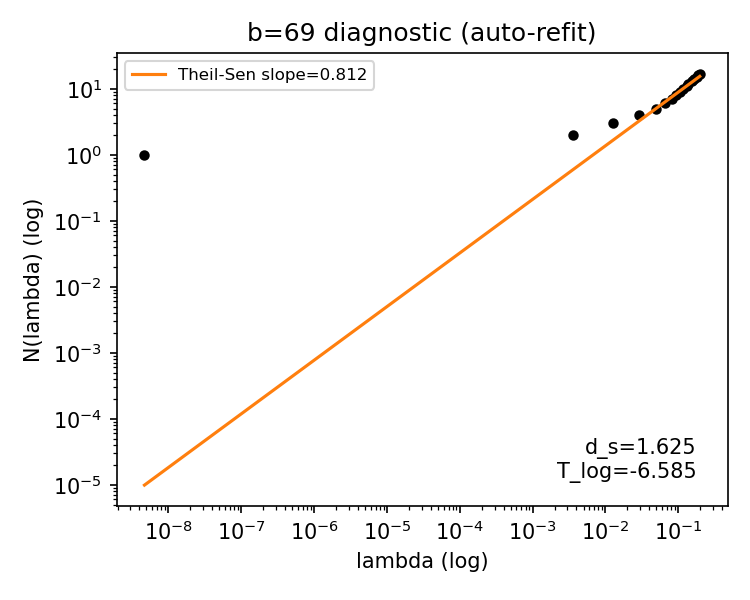

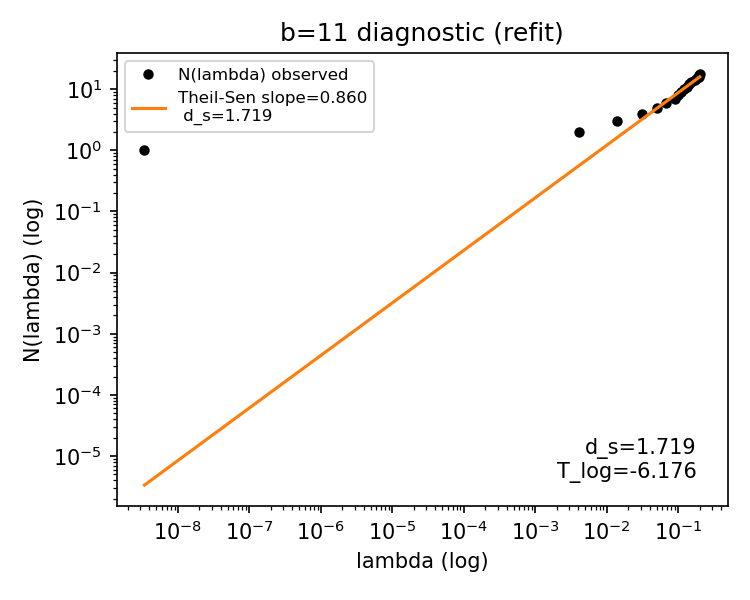

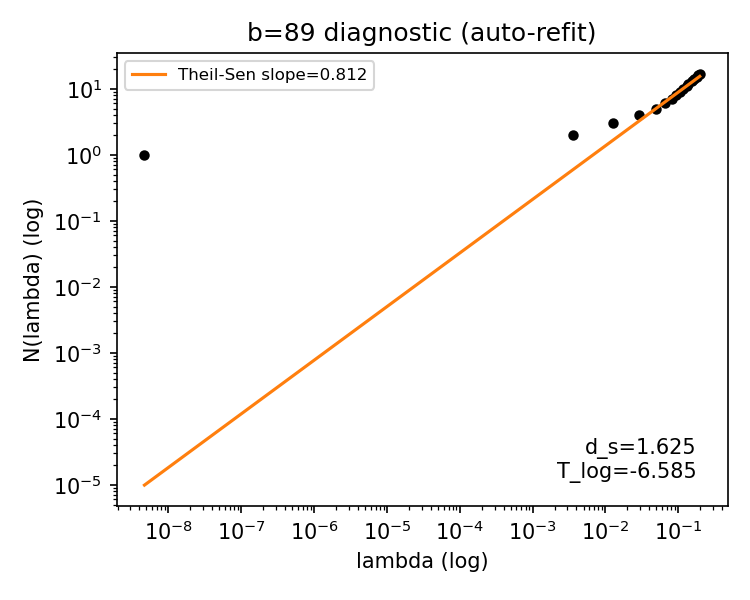

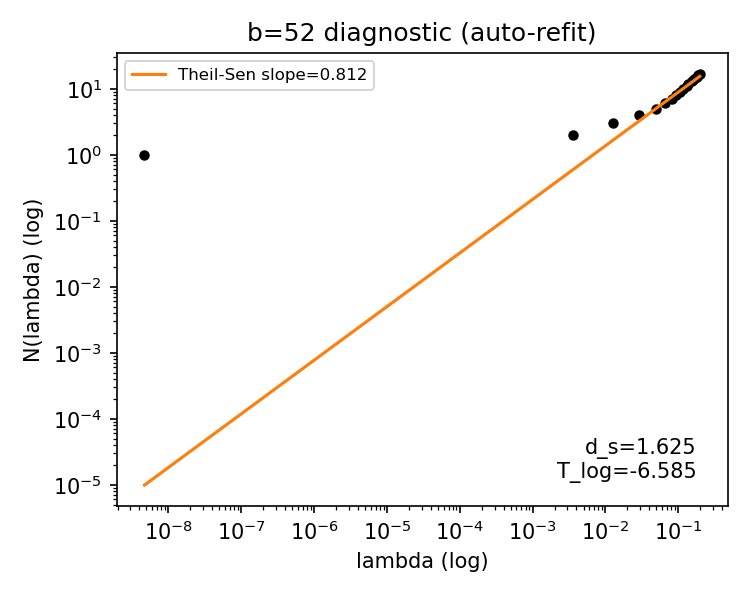

In [57]:
# Cellule: afficher inline les 5 PNG atypiques pour revue visuelle
from pathlib import Path
from IPython.display import display, Image, HTML

root = Path.cwd()
diag_dir = root / "diagnostics_theilsen_per_b_top15"
bs = [69, 11, 89, 52, 67]

html_parts = []
for b in bs:
    p = diag_dir / f"b_{int(b):03d}_diagnostic_rebuilt.png"
    exists = p.exists()
    caption = f"b={b} : {'FOUND' if exists else 'MISSING'}"
    if exists:
        # display inline image with caption
        display(HTML(f"<h4>{caption}</h4>"))
        display(Image(filename=str(p), width=700))
    else:
        display(HTML(f"<h4 style='color:darkred'>{caption} (no PNG)</h4>"))




In [58]:
# Cellule unique: reconstruire/refit uniquement pour b=67
from pathlib import Path
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import TheilSenRegressor
import matplotlib.pyplot as plt
from datetime import datetime
import json

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
match_ext = res_dir / "top15_match_report_extended.csv"
diag_out = root / "diagnostics_theilsen_per_b_top15"
diag_out.mkdir(exist_ok=True)
counting_dir = root / "results" / "spectral_diagnostics_counting"
canonical_ds = res_dir / "ds_robust_per_b.csv"

b = 67

def read_counting_from_path(p):
    p = Path(p)
    if not p.is_absolute():
        p = root / p
    if not p.exists():
        return None
    try:
        df = pd.read_csv(p)
    except Exception:
        return None
    cols = [c.lower() for c in df.columns]
    if "lambda" in cols:
        lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
        lam = pd.to_numeric(df[lam_col], errors="coerce").dropna().astype(float).values
        Ncol = None
        for c in df.columns:
            if c.lower() in ("n_lambda","n_lambda","N_lambda"):
                Ncol = c; break
        if Ncol:
            N = pd.to_numeric(df[Ncol], errors="coerce").dropna().astype(float).values
        else:
            N = np.arange(1, len(lam)+1)
        return lam, N, p
    # try eig cols
    eig_cols = [c for c in df.columns if "eig" in c.lower()]
    if eig_cols:
        ev = pd.to_numeric(df[eig_cols[0]], errors="coerce").dropna().astype(float).values
        if len(ev)==0:
            return None
        ev = np.sort(ev)
        lam = ev
        N = np.arange(1, len(ev)+1)
        return lam, N, p
    return None

def fit_theilsen_on_selection(lam, N):
    mask = (lam>0) & (N>0) & (lam <= 0.2)
    lam_sel = lam[mask]; N_sel = N[mask]
    if len(lam_sel) < 3:
        return None
    x = np.log(lam_sel).reshape(-1,1); y = np.log(N_sel)
    reg = TheilSenRegressor(random_state=0)
    reg.fit(x,y)
    slope = float(reg.coef_[0]); intercept = float(reg.intercept_)
    d_s = 2.0 * slope
    return {"slope": slope, "intercept": intercept, "d_s": d_s, "lam_sel": lam_sel, "N_sel": N_sel}

# load match report to find source if present
used_path = None
if match_ext.exists():
    mr = pd.read_csv(match_ext)
    row = mr[mr['b']==int(b)]
    if not row.empty:
        src = row.iloc[0].get('source', None)
        if pd.notna(src) and src:
            cand = read_counting_from_path(src)
            if cand:
                lam, N, used_path = cand

# try counting_dir name match
if used_path is None:
    pats = list(counting_dir.glob(f"*{b:03d}*counting.csv")) + list(counting_dir.glob(f"*_{b}_*counting.csv"))
    pats = [p for p in pats if p.exists()]
    if pats:
        cand = read_counting_from_path(pats[0])
        if cand:
            lam, N, used_path = cand

# fallback to generic diag_001_counting.csv
if used_path is None:
    generic = root / "results" / "spectral_diagnostics" / "diag_001_counting.csv"
    if generic.exists():
        cand = read_counting_from_path(generic)
        if cand:
            lam, N, used_path = cand

if 'lam' not in locals() or lam is None or N is None:
    print(f"[SKIP] b={b} : no usable source found (attempted match report, counting_dir, generic diag_001).")
else:
    res = fit_theilsen_on_selection(lam, N)
    if res is None:
        print(f"[SKIP] b={b} : fewer than 3 points with lambda <= 0.2 in source {used_path}")
    else:
        slope = res["slope"]; intercept = res["intercept"]; d_s = res["d_s"]
        lam_sel = res["lam_sel"]; N_sel = res["N_sel"]
        # compute Tlog using median n_points_fit if available
        ds = pd.read_csv(canonical_ds) if canonical_ds.exists() else pd.DataFrame()
        n_med = int(ds["n_points_fit"].median()) if ("n_points_fit" in ds.columns and len(ds)>0) else None
        Tlog = (d_s - 4.0) * math.log(n_med) if n_med and (not np.isnan(d_s)) else np.nan

        # backup canonical
        ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
        backup_fp = res_dir / "backups" / f"ds_robust_per_b_pre_refit_b{b}_{ts}.csv"
        backup_fp.parent.mkdir(exist_ok=True)
        if canonical_ds.exists():
            canonical_ds.replace(backup_fp)
            print("Backed up canonical ds_robust_per_b.csv to:", backup_fp)

        # update ds row
        if not ds.empty and (int(b) in ds["b"].astype(int).values):
            idx = ds[ds["b"].astype(int)==int(b)].index[0]
            ds.at[idx, "slope_used"] = slope
            ds.at[idx, "d_s_robust"] = d_s
            ds.at[idx, "Tlog_npoints_median"] = Tlog
            ds.at[idx, "n_points_fit"] = int(len(lam_sel))
            ds.at[idx, "lambda_max_used"] = float(np.max(lam_sel))
            ds.at[idx, "fit_ok"] = True
        else:
            rowobj = {"b": int(b), "slope_used": slope, "d_s_robust": d_s, "Tlog_npoints_median": Tlog,
                      "n_points_fit": int(len(lam_sel)), "lambda_max_used": float(np.max(lam_sel)), "fit_ok": True}
            ds = ds.append(rowobj, ignore_index=True)

        ds.to_csv(canonical_ds, index=False)

        # write PNG
        try:
            fig, ax = plt.subplots(figsize=(5,4))
            ax.loglog(lam_sel, N_sel, 'ok', markersize=4)
            x_line = np.linspace(np.log(lam_sel).min(), np.log(lam_sel).max(), 120)
            ax.loglog(np.exp(x_line), np.exp(intercept + slope * x_line), color='C1', label=f"Theil-Sen slope={slope:.3f}")
            ax.set_xlabel("lambda (log)")
            ax.set_ylabel("N(lambda) (log)")
            ax.set_title(f"b={b} diagnostic (reconstructed)")
            ax.text(0.95, 0.05, f"d_s={d_s:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
                    ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
            ax.legend(fontsize=8)
            fig.tight_layout()
            out_png = diag_out / f"b_{int(b):03d}_diagnostic_rebuilt.png"
            fig.savefig(out_png, dpi=150)
            plt.close(fig)
            print(f"[WRITE] b={b} refit done using {used_path} -> {out_png}")
        except Exception as e:
            print(f"[ERR] b={b} : failed to write PNG: {e}")

# write manifest of this single-action
manifest = {"action": "refit_single_b", "b": b, "timestamp": datetime.utcnow().isoformat()+"Z", "used_source": str(used_path) if used_path else None}
mf = res_dir / f"manifest_refit_b{b}_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"
with open(mf, "w", encoding="utf8") as f:
    json.dump(manifest, f, indent=2)
print("Manifest written:", mf)


Backed up canonical ds_robust_per_b.csv to: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\backups\ds_robust_per_b_pre_refit_b67_20251111T012900Z.csv
[WRITE] b=67 refit done using c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\spectral_diagnostics\diag_001_counting.csv -> c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_067_diagnostic_rebuilt.png
Manifest written: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\manifest_refit_b67_20251111T012902Z.json


In [60]:
# Cellule corrigée : recalcul T_log summary et manifest_from_run.json (gestion robuste des chemins)
from pathlib import Path
import pandas as pd
import hashlib, json, os
from datetime import datetime
import numpy as np

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
canonical = res_dir / "ds_robust_per_b.csv"
summary_fp = res_dir / "Tlog_final_summary.csv"
manifest_fp = res_dir / "manifest_from_run.json"
run_ready = res_dir / "run_ready_for_commit.txt"
match_ext = res_dir / "top15_match_report_extended.csv"

def sha1_of(p):
    try:
        h = hashlib.sha1()
        with open(p, "rb") as fh:
            while True:
                b = fh.read(8192)
                if not b: break
                h.update(b)
        return h.hexdigest()
    except Exception:
        return None

if not canonical.exists():
    raise FileNotFoundError("Canonical ds not found: " + str(canonical))

df = pd.read_csv(canonical)

# ensure Tlog column exists
if "Tlog_npoints_median" not in df.columns:
    raise ValueError("ds_robust_per_b.csv missing Tlog_npoints_median column")

t = pd.to_numeric(df["Tlog_npoints_median"], errors="coerce").dropna()
summary = {
    "count_b": int(len(df)),
    "Tlog_count": int(len(t)),
    "Tlog_median": float(t.median()) if len(t)>0 else None,
    "Tlog_q025": float(t.quantile(0.025)) if len(t)>0 else None,
    "Tlog_q975": float(t.quantile(0.975)) if len(t)>0 else None,
    "Tlog_mean": float(t.mean()) if len(t)>0 else None,
    "Tlog_std": float(t.std()) if len(t)>0 else None
}

# write summary CSV
pd.DataFrame([summary]).to_csv(summary_fp, index=False)

# build artifact list: prefer run_ready file if exists
artifacts = []
if run_ready.exists():
    txt = run_ready.read_text(encoding="utf8", errors="replace")
    for line in txt.splitlines():
        line = line.strip()
        if line.startswith("- "):
            p = line[2:].strip()
            artifacts.append(Path(p))
# fallback set of known files if run_ready had none
if not artifacts:
    artifacts = [
        canonical,
        summary_fp,
        res_dir / "Tlog_per_b_final.csv",
        res_dir / "top15_Tlog_closest_to_zero.csv",
        res_dir / "top15_match_report.csv",
        res_dir / "top15_match_report_extended.csv",
        res_dir / "run_ready_for_commit.txt"
    ]
    diag_dir = root / "diagnostics_theilsen_per_b_top15"
    if diag_dir.exists():
        artifacts += sorted(list(diag_dir.glob("b_*_diagnostic_rebuilt.png")))

# dedupe and keep only existing
seen = set()
final_artifacts = []
for p in artifacts:
    if not p:
        continue
    # if path seems relative, resolve against root; if already absolute, keep
    p_abs = (root / p) if not p.is_absolute() and (root / p).exists() else p
    if not p_abs.exists():
        # try direct Path(p) if string was absolute already
        p_abs = Path(p)
    if p_abs.exists():
        key = str(p_abs.resolve())
        if key not in seen:
            seen.add(key)
            final_artifacts.append(p_abs)

# collect source_used from extended match report if available
source_map = {}
if match_ext.exists():
    mr = pd.read_csv(match_ext)
    if "b" in mr.columns and "source" in mr.columns:
        for _, r in mr.iterrows():
            try:
                source_map[int(r["b"])] = r["source"] if pd.notna(r["source"]) else None
            except Exception:
                continue

manifest = {
    "generated_at": datetime.utcnow().isoformat()+"Z",
    "summary": summary,
    "artifacts": []
}

for p in final_artifacts:
    # compute a safe relative path (use os.path.relpath to avoid ValueError)
    try:
        rel = os.path.relpath(str(p.resolve()), str(root.resolve()))
    except Exception:
        rel = str(p.resolve())
    item = {"path": rel, "sha1": sha1_of(p)}
    # attach source_used if this artifact is a diagnostic png b_XXX
    name = p.stem
    if name.startswith("b_"):
        try:
            bnum = int(name.split("_")[1])
            item["source_used"] = source_map.get(bnum, None)
        except Exception:
            item["source_used"] = None
    manifest["artifacts"].append(item)

# write manifest JSON
with open(manifest_fp, "w", encoding="utf8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

# update run_ready_for_commit.txt
with open(run_ready, "w", encoding="utf8") as f:
    f.write(f"Run summary generated at: {datetime.utcnow().isoformat()}Z\n")
    f.write("Artifacts to commit:\n")
    for it in manifest["artifacts"]:
        f.write(f"- {it['path']}\n")
    f.write("\nTlog summary:\n")
    for k,v in summary.items():
        f.write(f"{k}: {v}\n")
    f.write("\nNote: certains diagnostics ont été refit en utilisant diag_001_counting.csv en fallback lorsque les counting par-b n'étaient pas disponibles ; voir manifest_from_run.json pour source_used par PNG.\n")

print("Wrote Tlog summary:", summary_fp)
print("Wrote manifest:", manifest_fp)
print("Updated run_ready_for_commit.txt:", run_ready)
print("\nTlog summary (console):")
for k,v in summary.items():
    print(f"- {k}: {v}")


Wrote Tlog summary: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\Tlog_final_summary.csv
Wrote manifest: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\manifest_from_run.json
Updated run_ready_for_commit.txt: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\run_ready_for_commit.txt

Tlog summary (console):
- count_b: 150
- Tlog_count: 150
- Tlog_median: -6.618064219773288
- Tlog_q025: -6.924484843625584
- Tlog_q975: -6.368963527507544
- Tlog_mean: -6.6314834548173085
- Tlog_std: 0.1610101874895739
